In [3]:
# Install txtai and elasticsearch python client
!pip install git+https://github.com/neuml/txtai elasticsearch

# Download and extract elasticsearch
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.8.1-linux-x86_64.tar.gz
!tar -xzf elasticsearch-7.8.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.8.1

  Cloning https://github.com/neuml/txtai to /tmp/pip-req-build-czq5vm1n
  Created wheel for txtai: filename=txtai-1.4.0-py3-none-any.whl size=23246 sha256=7a7fd6a49cebdd65138794892f67843bda2da1d2f5b34286e60883d448d4f168
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ua9_5ce/wheels/83/d6/ae/6b41733966092887bf61f691622261d990943588a03e5cd0be
Successfully built txtai
--2020-11-12 23:11:42--  https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.8.1-linux-x86_64.tar.gz
Resolving artifacts.elastic.co (artifacts.elastic.co)... 151.101.250.222, 2a04:4e42:2f::734
Connecting to artifacts.elastic.co (artifacts.elastic.co)|151.101.250.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318334518 (304M) [application/x-gzip]
Saving to: ‘elasticsearch-7.8.1-linux-x86_64.tar.gz.1’

elasticsearch-7.8.1 100%[===================>] 303.59M  50.7MB/s    in 8.0s    

2020-11-12 23:11:51 (38.1 MB/s) - ‘elasticsearch-7.8.1-linux-x86_64.tar.gz.1’ saved [318334518/3

In [4]:
import os
from subprocess import Popen, PIPE, STDOUT

# Start and wait for server
server = Popen(['elasticsearch-7.8.1/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
from elasticsearch import Elasticsearch
es = Elasticsearch(hosts=["http://localhost:9200"], timeout=60, retry_on_timeout=True)
es.indices.create(index="environment", ignore=400)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'environment'}

In [6]:
lines=[]
with open('../input/combined/tvnews_corpus.tsv', 'r', errors='replace') as f:
    lines = f.readlines()

In [7]:
from tqdm import tqdm
import csv
counter = 1
finalMapping = dict()

for dirname,_,filenames in os.walk('../input/environmental-news-nlp-dataset/TelevisionNews'):
    for filename in tqdm(filenames, "progress"):
        path = os.path.join(dirname, filename)
        with open(path, 'r', errors='replace') as file: 
            reader = csv.reader(file)
            dictForRow = dict()
            rowNum = 0
            for row in reader:
                if(rowNum!=0):
                    dictForRow['snippet'] = row[6]
                    strBuilder = str(filename) + "#" + str(rowNum)
                    finalMapping[counter] = strBuilder
                    es.index(index="environment", doc_type="env", id=strBuilder, body=dictForRow)
                    counter += 1
                rowNum+=1

progress:   0%|          | 0/418 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: [types removal] Specifying types in document index requests is deprecated, use the typeless endpoints instead (/{index}/_doc/{id}, /{index}/_doc, or /{index}/_create/{id}).
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
progress: 100%|██████████| 418/418 [17:30<00:00,  2.51s/it]


In [ ]:
res = es.search(index="environment", body={"from":0, "size":10000, "min_score":0, "query":{"match":{"snippet":"Global warming is a hoax"}}})


In [8]:
!pip install pywsd

     |████████████████████████████████| 26.8 MB 27.9 MB/s eta 0:00:01
     |████████████████████████████████| 31.6 MB 173 kB/s  eta 0:00:01
  Created wheel for pywsd: filename=pywsd-1.2.4-py3-none-any.whl size=26940452 sha256=64fbd32ab40edb05f9ae8bf1012a0045338178eb7628903605f0e10889796016
  Stored in directory: /root/.cache/pip/wheels/56/67/c0/6e6fa8456d1374b393328368316c3b33844cb4043bd225bc66
  Created wheel for wn: filename=wn-0.0.23-py3-none-any.whl size=31792943 sha256=75f0fc8a8aa29d71ffc920dd4943fd681de58add4cae4b06018e9508bc9fc45c
  Stored in directory: /root/.cache/pip/wheels/ec/47/17/409766c99dd470f34c512000b90b83f34747c2c975769654d7
Successfully built pywsd wn


In [9]:
import pickle
import operator
import time
from pywsd.utils import lemmatize_sentence
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(v1,v2):
    return dot(v1, v2)/(norm(v1)*norm(v2))

# The inverted index file contents are loaded into memory
# All queries will be analyzed with this, so it is fine to preload
with open("../input/indexing/inv_index_percsv_version","rb") as f:
    posting_list = pickle.load(f)
    file_dict = pickle.load(f)
    vocab = pickle.load(f)

# The actual data is also loaded to be display the search results
fileobj = open('../input/combined/tvnews_corpus.tsv','r', errors='ignore')
lines = fileobj.readlines()
fileobj.close()

def searchAPI(searchterm):
    query = searchterm
    query_tokens = lemmatize_sentence(query) # lemmatize tokens to use as in vocabulary
    query_vector = []
    query_tf = {}
    total_query_vocab = 0
    for tok in query_tokens:
        try:
            indexvalue = vocab.index(tok)
            query_vector.append(indexvalue)
            query_tf[indexvalue] = 1 + query_tf.get(indexvalue,0)
            total_query_vocab += 1
        except ValueError: # Token doesnt exist in vocab - ignored
            deadcode='a'


    start_time = time.time() # Timer starts

    # First we obtain the list of all possible documents we actually need to search
    # This is a union of the docs in each query term's posting list
    # Not an intersection because we use cosine similarity and not boolean retrieval
    possible_docs = set()
    query_tf_vector = []

    for q in query_vector:
        possible_docs = possible_docs.union(posting_list[q].keys())
        query_tf_vector.append(query_tf[q]/total_query_vocab)
        # We also generate a TDF vector for the query. Does not make sense to scale with IDF

    # Run through each doc and generate the vector corresponding to the query terms
    # Compute the cosine similarities of it vs the TF vector of the query
    # Ties are broken by the magnitude of the vector - note that this is obtained by only considering the query terms
    # Plus these query term weights were scaled with relative TF, so a higher magnitude means the terms were more important
    doc_scores = {}
    for doc in possible_docs:
        doc_vector = []
        for q in query_vector:
            doc_vector.append(posting_list[q].get(doc,0))
        doc_scores[doc] = (cosine_similarity(doc_vector,query_tf_vector), norm(doc_vector))

    # Results are sorted
    sorted_results = sorted(doc_scores.items(), key=operator.itemgetter(1), reverse=True)

    end_time = time.time() # Timer ends as search portion is complete
    search_time = end_time - start_time

    ct = 1
    #print("-------------- SEARCH RESULTS --------------")
    results={}
    results['Details']=[]
    results['Documents']=[]
    for i in sorted_results:
        fname, rownum = file_dict[i[0]].split(' ')
        rownum = int(rownum[3:])
        search_res = lines[i[0]]
        search_res = search_res.split('\t')[2]
        answer=fname+'#'+str(rownum+1)
        results['Documents'].append(answer.split('\\')[-1])
        results['Details'].append({'Name': fname+'#'+str(rownum+1), 'Score': i[1], 'Results': search_res})
        ct += 1
    results['Time']=end_time-start_time
    return results

Warming up PyWSD (takes ~10 secs)... took 9.61838674545288 secs.


In [10]:
def retrivetopkelastic(hits):
    topk=[]
    for i in range(0,len(hits)):
        topk.append(hits[i]['_id'])
    return topk

def retrievaAllElastic(line):
    total=[]
    data = es.search(index="environment",scroll='2m', body={"from":0, "size": 10000, "min_score":0, "query":{"match":{"snippet":line}}})
    sid = data['_scroll_id']
    scroll_size = len(data['hits']['hits'])
    while scroll_size > 0:
        scroll_size = len(data['hits']['hits'])
        total+=[id['_id'] for id in data['hits']['hits']]
        data = es.scroll(scroll_id=sid, scroll='2m')
        sid = data['_scroll_id']
    return total

In [18]:
import time

testcasefile="../input/samplequeries/sample_queries.txt"
inputfile= open(testcasefile,"r")
timelist1=[]
timelist2=[]

retrieved=[]
relevant=[]

for line in tqdm((inputfile.read()).split('\n'), "progress"):
    
    #SearchAPI
    results = searchAPI(line)
    timelist1.append(results['Time'])
    retrieved.append(results['Documents'])
    
    #Elastic Search
    tic=time.time()
    relevant.append(retrievaAllElastic(line))
    toc=time.time()
    timelist2.append(toc-tic)

progress: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it]


In [21]:
with open("resultsfinalv1","wb") as f:
    pickle.dump(retrieved,f)
    pickle.dump(relevant, f)
    pickle.dump(timelist1,f)
    pickle.dump(timelist2,f)

78906

In [72]:
precisionnum = 0
precisionden = 0
for i in range(50):
    precisionnum+=len(set(retrieved[i][:10]).intersection(relevant[i]))
    precisionden+=len(set(retrieved[i][:10]))
print(precisionnum/precisionden)

recallnum = 0
recallden = 0
for i in range(50):
    recallnum+=len(set(retrieved[i][:10]).intersection(relevant[i]))
    recallden+=len(set(relevant[i]))
print(recallnum/recallden)

0.938
0.0002680957484816006


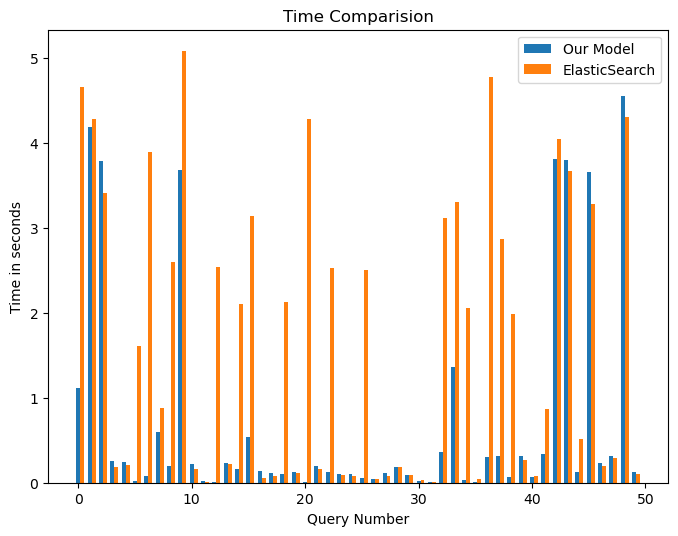

In [85]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(8, 6), dpi=100)
ind = np.arange(50) 
width = 0.35       
plt.bar(ind, timelist1, width, label='Our Model')
plt.bar(ind + width, timelist2, width,
    label='ElasticSearch')

plt.xlabel("Query Number")
plt.ylabel('Time in seconds')
plt.title('Time Comparision')

# plt.xticks(ind + width / 2, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.legend(loc='upper right')
plt.show()

In [65]:
sentences

['']

In [103]:
precisions = []
recalls = []
for k in tqdm(range(1,1000,10), 'progress'):
    precisionnum = 0
    precisionden = 0
    for i in range(50):
        precisionnum+=len(set(retrieved[i][:k]).intersection(relevant[i]))
        precisionden+=len(set(retrieved[i][:k]))
    precisions.append(precisionnum/precisionden)

    recallnum = 0
    recallden = 0
    for i in range(50):
        recallnum+=len(set(retrieved[i][:k]).intersection(relevant[i]))
        recallden+=len(set(relevant[i]))
    recalls.append(recallnum/recallden)

progress: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


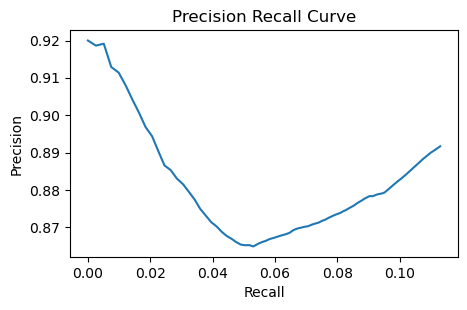

In [104]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(5, 3), dpi=100)
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.title('Precision Recall CUrb')
plt.ylabel("Precision")
plt.show()

<a href="./elasticsearch-7.8.1"> Download File </a>